In [92]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import platform
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

In [93]:
font_location = 'C:/Users/yeonn/AppData/Local/Microsoft/Windows/Fonts/D2Coding-Ver1.3.2-20180524-all.ttc' 
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

전처리 및 최적 군집 개수 선정 

In [94]:
df = pd.read_csv('data6.csv', index_col=0)
df = df.loc[:, ~df.columns.isin(['창업이전', '창업이후'])]

In [95]:
df

,기업형태,창업자 학력,창업횟수,창업인원,사업장 입지,매출액,영업이익,금융비용(이자비용),당기순이익,B2C 소비자 매출(%),B2G 정부 매출(%),연간 자금 사용금액,전체 인력,자산대비 자금사용비율
0,법인,중졸이하,1,1,일반주택,265000,15100.0,900.0,4750.0,100,0,101850.0,1,55.218459
2,법인,중졸이하,2,2,일반상업,677000,63045.0,29020.0,46147.0,100,0,136948.0,4,970.206210
3,법인,중졸이하,1,1,일반주택,3936000,264000.0,34300.0,139300.0,0,0,288880.0,17,32.130989
4,법인,중졸이하,1,1,일반주택,5668000,170900.0,18300.0,144850.0,100,0,572130.0,26,15.765648
5,법인,중졸이하,1,1,산업단지,85000,2100.0,1200.0,2050.0,100,0,110900.0,2,1896.979261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31974,법인,대졸,1,3,일반주택,524000,152900.0,0.0,110300.0,0,0,882000.0,6,15.873016
31975,법인,대졸,1,1,일반상업,782300,31200.0,0.0,22500.0,0,0,380000.0,9,23.947368
31976,개인,대졸,1,1,기타,526000,191900.0,0.0,138500.0,100,0,16000.0,7,481.250000
31977,개인,대졸,1,1,일반주택,620000,201500.0,400.0,145400.0,70,0,1162800.0,15,12.039904


In [96]:
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
df['기업형태'] = np.where(df['기업형태'] == '법인', 1, 0)
df.rename(columns={'기업형태':'법인기업'}, inplace=True)
df['창업자 학력'].value_counts()
df['창업자학력'] = df['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df = df.drop('창업자 학력', axis=1)
df['창업자학력'].value_counts()
df['사업장 입지'].value_counts()
df['상업지역'] = df['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df = df.drop('사업장 입지', axis=1)
df['상업지역'].value_counts()
df

scale_col = ['매출액', '영업이익', '금융비용(이자비용)', '당기순이익', '연간 자금 사용금액', '자산대비 자금사용비율']
scaler = StandardScaler()
df[scale_col] = scaler.fit_transform(df[scale_col])

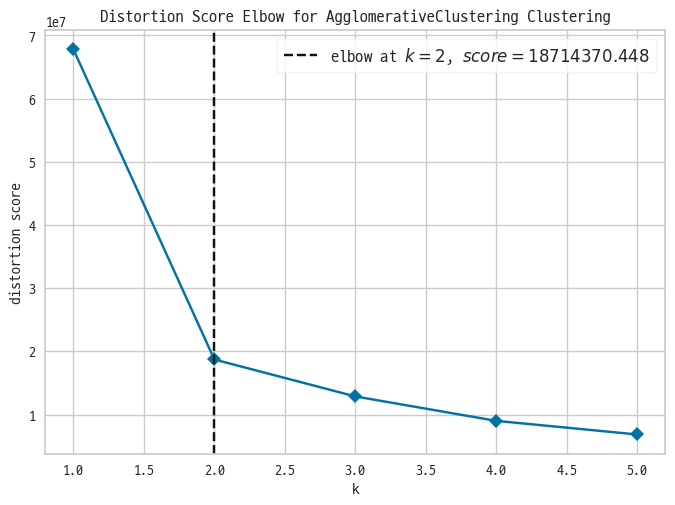

cluster : 2 // silhouette index 0.7973003375280503
cluster : 3 // silhouette index 0.8181735915008863
cluster : 4 // silhouette index 0.8284600500451755
cluster : 5 // silhouette index 0.829572509450373


In [97]:
from sklearn.metrics import silhouette_score, silhouette_samples

k=0
agg = AgglomerativeClustering(n_clusters=k)
visualizer = KElbowVisualizer(agg, k=(1,6), timings=False)
visualizer.fit(df)
visualizer.show()

for k in range(2, 6):
    agg = AgglomerativeClustering(n_clusters=k).fit(df)
    silhouette_avg = silhouette_score(df, agg.labels_)
    print(f'cluster : {k} // silhouette index {silhouette_avg}')

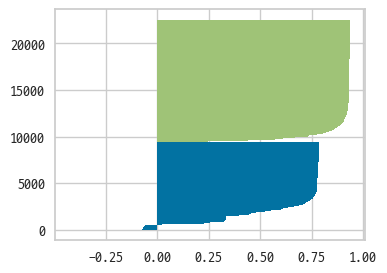

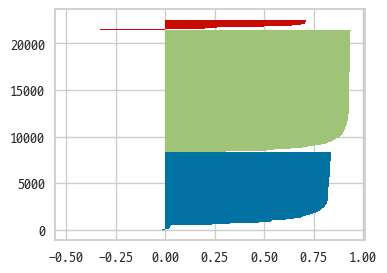

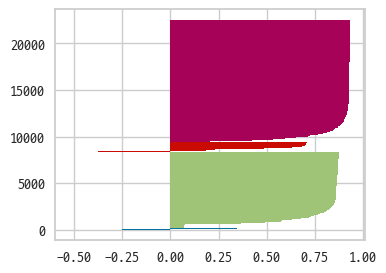

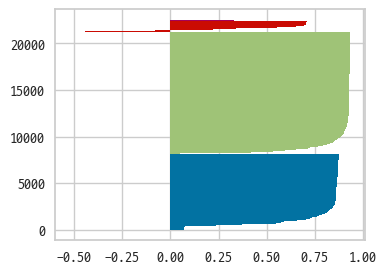

In [98]:
for k in range(2, 6):
    fig, ax = plt.subplots(1, 1,figsize=(4,3))
    agg = AgglomerativeClustering(n_clusters=k).fit(df)
    silhouette_vals = silhouette_samples(df, agg.labels_)
    y_ticks = []
    y_lower = y_upper = 0
    for c_num in np.unique(agg.labels_):
        cluster_silhouette_vals = silhouette_vals[agg.labels_==c_num]
        y_upper += len(cluster_silhouette_vals)
        cluster_silhouette_vals.sort() 
        
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
        y_lower += len(cluster_silhouette_vals)

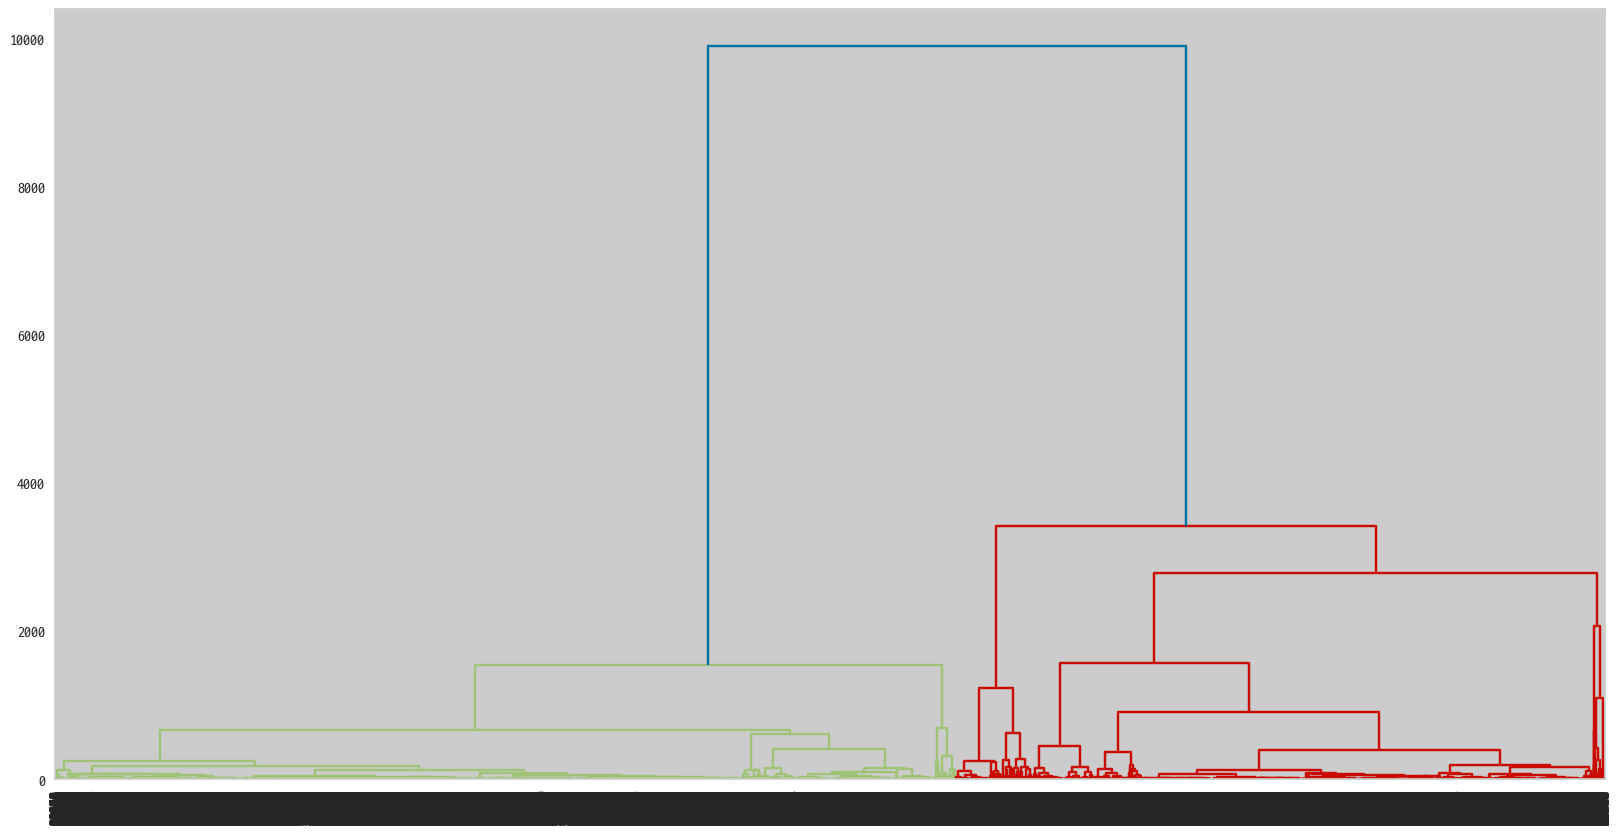

In [99]:
# 군집 방식은 ward로 거리는 유크리디안으로 측정해 최적의 군집 개수 분석
clusters = linkage(df, method='ward', metric='euclidean')

# 덴드로그램 그리기
plt.figure(figsize=(20, 10))              
dendrogram(clusters,
           #leaf_rotation=50, # 라벨 50% 기울이기
           leaf_font_size=10, # 라벨 폰트 크기
           labels=df.index) # 라벨에 사용할 변수
plt.show()

군집화

In [111]:
df = pd.read_csv('data6.csv', index_col=0)
df = df.loc[:, ~df.columns.isin(['창업이전', '창업이후'])]
df['기업형태'] = np.where(df['기업형태'] == '법인', 1, 0)
df.rename(columns={'기업형태':'법인기업'}, inplace=True)
df['창업자 학력'].value_counts()
df['창업자학력'] = df['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df = df.drop('창업자 학력', axis=1)
df['창업자학력'].value_counts()
df['사업장 입지'].value_counts()
df['상업지역'] = df['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df = df.drop('사업장 입지', axis=1)
df['상업지역'].value_counts()
df

scale_col = ['매출액', '영업이익', '금융비용(이자비용)', '연간 자금 사용금액', '자산대비 자금사용비율']
scaler = StandardScaler()
df[scale_col] = scaler.fit_transform(df[scale_col])

In [112]:
def replace_space_with_underscore(df):
    df.columns = df.columns.str.replace(' ', '')
    return df

# 데이터프레임의 열 이름에서 공백을 언더스코어로 대체
df = replace_space_with_underscore(df)
df.rename(columns={'B2G정부매출(%)': 'B2G정부매출'}, inplace=True)
df.rename(columns={'B2C소비자매출(%)': 'B2C소비자매출'}, inplace=True)
df.rename(columns={'금융비용(이자비용)': '금융비용'}, inplace=True)


In [113]:
df.columns

Index(['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율', '창업자학력', '상업지역'],
      dtype='object')

In [114]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df['당기순이익_scale'] = scaler.fit_transform(train_df[['당기순이익']])
agg = AgglomerativeClustering(n_clusters=3)
pre_col=['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익_scale', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율', '창업자학력', '상업지역']
train_df['AgglomerativeClustering']=agg.fit_predict(train_df[pre_col])
train_df.drop(axis=1,columns='당기순이익_scale',inplace= True)

군집분석

In [115]:
df_군집0=train_df[train_df['AgglomerativeClustering']==0]
df_군집1=train_df[train_df['AgglomerativeClustering']==1]
df_군집2=train_df[train_df['AgglomerativeClustering']==2]

In [116]:
df_군집0.drop(axis=1,columns='AgglomerativeClustering',inplace=True)
df_군집1.drop(axis=1,columns='AgglomerativeClustering',inplace=True)
df_군집2.drop(axis=1,columns='AgglomerativeClustering',inplace=True)

C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\1926280889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_군집0.drop(axis=1,columns='AgglomerativeClustering',inplace=True)
C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\1926280889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_군집1.drop(axis=1,columns='AgglomerativeClustering',inplace=True)
C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\1926280889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [117]:
train_df['AgglomerativeClustering'].value_counts()

AgglomerativeClustering
1    10247
0     6874
2      911
Name: count, dtype: int64

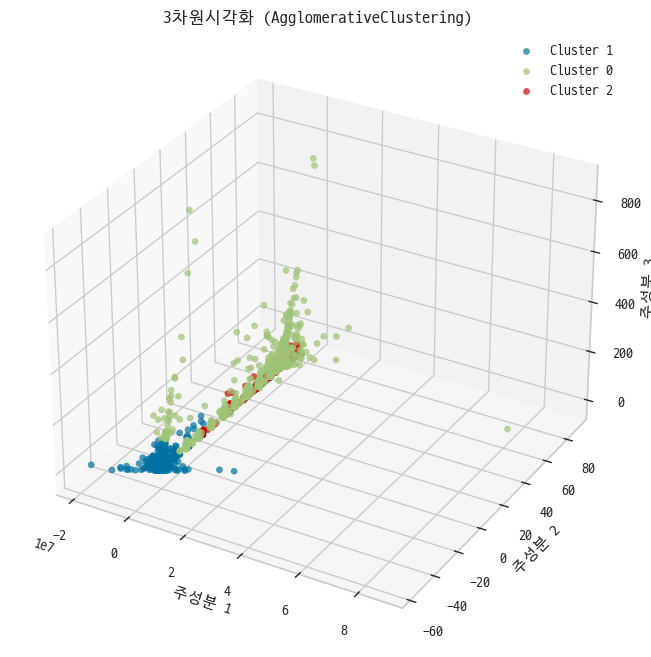

In [143]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 3차원으로 축소
pca = PCA(n_components=3)
principal_components = pca.fit_transform(train_df)

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# 군집 레이블별로 데이터를 색깔별로 구분하여 시각화
for cluster_label in train_df['AgglomerativeClustering'].unique():
    cluster_data = principal_components[train_df['AgglomerativeClustering'] == cluster_label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', alpha=0.7)

ax.set_xlabel('주성분 1')
ax.set_ylabel('주성분 2')
ax.set_zlabel('주성분 3')
ax.set_title('3차원시각화 (AgglomerativeClustering)')
ax.legend()
plt.show()

회귀요인 통계적분석

In [118]:
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels
from patsy import dmatrices

In [119]:
y, X = dmatrices('당기순이익 ~ 법인기업  + 창업횟수 + 창업인원 + 창업자학력+'
                 ' 매출액 + 영업이익 + 금융비용 +상업지역+ '
                 'B2C소비자매출 + B2G정부매출 + 연간자금사용금액 + 전체인력  + '
                 ' 자산대비자금사용비율', 
                 data=df_군집0, return_type="dataframe")

# 회귀 모델 피팅
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  당기순이익   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        01:34:00   Log-Likelihood:                -95441.
No. Observations:                6874   AIC:                         1.909e+05
Df Residuals:                    6860   BIC:                         1.910e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.651e+04   1.38e+04      3.379      0.0

In [120]:
y, X = dmatrices('당기순이익 ~ 법인기업  + 창업횟수 + 창업인원 + 창업자학력+'
                 ' 매출액 + 영업이익 + 금융비용 +상업지역+ '
                 'B2C소비자매출 + B2G정부매출 + 연간자금사용금액 + 전체인력  + '
                 ' 자산대비자금사용비율', 
                 data=df_군집1, return_type="dataframe")

# 회귀 모델 피팅
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  당기순이익   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     4272.
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        01:34:00   Log-Likelihood:            -1.3943e+05
No. Observations:               10247   AIC:                         2.789e+05
Df Residuals:                   10233   BIC:                         2.790e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.086e+04   1.48e+05      0.545      0.5

In [121]:
y, X = dmatrices('당기순이익 ~ 법인기업  + 창업횟수 + 창업인원 + 창업자학력+'
                 ' 매출액 + 영업이익 + 금융비용 +상업지역+ '
                 'B2C소비자매출 + B2G정부매출 + 연간자금사용금액 + 전체인력  + '
                 ' 자산대비자금사용비율', 
                 data=df_군집2, return_type="dataframe")

# 회귀 모델 피팅
model = sm.OLS(y, X)
results = model.fit()

# 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  당기순이익   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     233.2
Date:                Fri, 31 May 2024   Prob (F-statistic):          6.46e-277
Time:                        01:34:00   Log-Likelihood:                -12022.
No. Observations:                 911   AIC:                         2.407e+04
Df Residuals:                     897   BIC:                         2.414e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.331e+04   2.52e+04      1.322      0.1

모델성능분석

In [122]:
X_test=test_df.drop(axis=1,columns='당기순이익')
y_test=test_df['당기순이익']

In [123]:
X_0 = df_군집0.drop(columns=['당기순이익'], axis=1)
y_0 = df_군집0['당기순이익']

X_1 = df_군집1.drop(columns=['당기순이익'], axis=1)
y_1 = df_군집1['당기순이익']

X_2 = df_군집2.drop(columns=['당기순이익'], axis=1)
y_2 = df_군집2['당기순이익']


X_3 = df_군집3.drop(columns=['당기순이익'], axis=1)
y_3 = df_군집3['당기순이익']

X_4 = df_군집4.drop(columns=['당기순이익'], axis=1)
y_4 = df_군집4['당기순이익']

linear 회귀 지표

In [124]:
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()


#각 군집에 대한 모델 훈련
model_0.fit(X_0, y_0)
model_1.fit(X_1, y_1)
model_2.fit(X_2, y_2)



y_0_pred = model_0.predict(X_test)
y_1_pred = model_1.predict(X_test)
y_2_pred = model_2.predict(X_test)


 #각 군집에 대한 테스트 데이터에 모델 적용하여 성능 평가
rmse_0 = root_mean_squared_error(y_test, y_0_pred)
rmse_1 = root_mean_squared_error(y_test, y_1_pred)
rmse_2 = root_mean_squared_error(y_test, y_2_pred)


r2_0 = r2_score(y_test, y_0_pred)
r2_1 = r2_score(y_test, y_1_pred)
r2_2 = r2_score(y_test, y_2_pred)


In [125]:
print("군집 0의 선형회귀 R^2 값:", r2_0)
print("군집 1의 선형회귀 R^2 값:", r2_1)
print("군집 2의 선형회귀 R^2 값:", r2_2)

print()
print("군집 0의 선형회귀 RMSE:", rmse_0)
print("군집 1의 선형회귀 RMSE:", rmse_1)
print("군집 2의 선형회귀 RMSE:", rmse_2)


군집 0의 선형회귀 R^2 값: 0.31244827581509915
군집 1의 선형회귀 R^2 값: 0.4344084386404913
군집 2의 선형회귀 R^2 값: 0.6653153228341993

군집 0의 선형회귀 RMSE: 589680.9358280618
군집 1의 선형회귀 RMSE: 534830.1234860112
군집 2의 선형회귀 RMSE: 411417.0771202257


Ridge 모델로 하이퍼 파라미터 수정

In [144]:
from sklearn.linear_model import Ridge
import optuna


ri = Ridge()
def linear_objective(trial):
    # 하이퍼파라미터 탐색 공간 설정
    alpha = trial.suggest_float('alpha', 0.0, 100.0)  # alpha 값을 0부터 100까지의 범위로 설정
    # Ridge 모델 생성
    ri = Ridge(alpha=alpha)
    # Ridge 모델 학습
    ri.fit(X_2, y_2)
    # Ridge 모델 예측
    y_pred = ri.predict(X_test)
    # R^2 점수 계산
    r2 = r2_score(y_test, y_pred)
    return r2

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(linear_objective, n_trials=100)

# 최적의 하이퍼파라미터 및 R^2 점수 출력
print("Best trial:")
print(study.best_trial.params)
print("Best R^2 score:")
print(study.best_trial.value)

# 최적의 하이퍼파라미터로 모델 재훈련 및 조정된 R^2 계산
best_params = study.best_trial.params
best_model = Ridge(**best_params)
best_model.fit(X_2, y_2)
y_pred = best_model.predict(X_test)

# R^2 점수 계산
r2 = r2_score(y_test, y_pred)
rmse=root_mean_squared_error(y_test,y_pred)

# 결과 출력
print(f'R^2 score: {r2}')
print(f'rmse: {rmse}')

[I 2024-05-31 01:52:41,445] A new study created in memory with name: no-name-c9e584da-edb9-4a67-8354-d3d23c7bbdce
[I 2024-05-31 01:52:41,452] Trial 0 finished with value: 0.5810871653311431 and parameters: {'alpha': 86.1960873236557}. Best is trial 0 with value: 0.5810871653311431.
[I 2024-05-31 01:52:41,458] Trial 1 finished with value: 0.648653363250882 and parameters: {'alpha': 32.69370132342476}. Best is trial 1 with value: 0.648653363250882.
[I 2024-05-31 01:52:41,463] Trial 2 finished with value: 0.5669850169219738 and parameters: {'alpha': 98.84146819920005}. Best is trial 1 with value: 0.648653363250882.
[I 2024-05-31 01:52:41,469] Trial 3 finished with value: 0.6129917149745958 and parameters: {'alpha': 60.06825206239006}. Best is trial 1 with value: 0.648653363250882.
[I 2024-05-31 01:52:41,476] Trial 4 finished with value: 0.5817191005729614 and parameters: {'alpha': 85.64735525579154}. Best is trial 1 with value: 0.648653363250882.
[I 2024-05-31 01:52:41,485] Trial 5 finish

Best trial:
{'alpha': 7.475632422159165}
Best R^2 score:
0.6698047958361346
R^2 score: 0.6698047958361346
rmse: 408648.3787482486


시각화

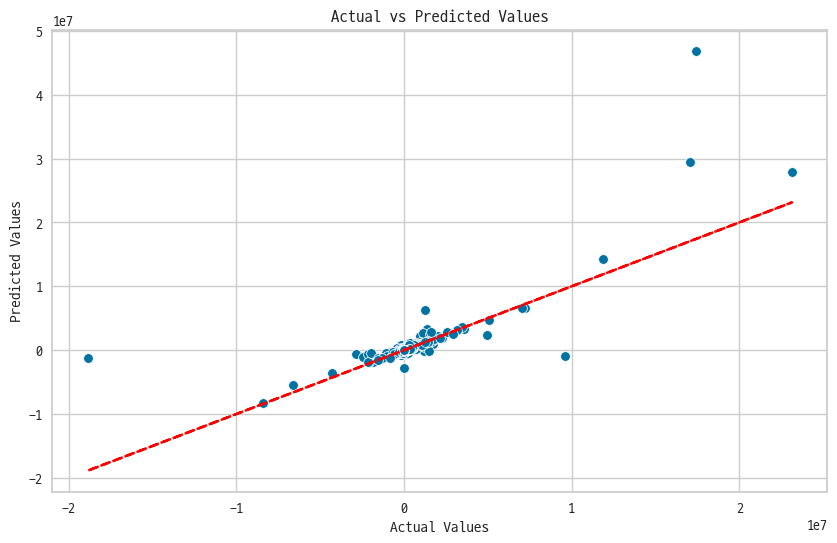

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# 제일 좋은 수치모델로 시각화
predicted_values = best_model.predict(X_test)
actual_values = y_test

# 산점도와 회귀선 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.plot(actual_values, actual_values, color='red', linestyle='--')

plt.show()

XGB 회귀 지표

In [133]:
from xgboost import XGBRegressor

model_0_xgb = xgb.XGBRegressor()
model_1_xgb = xgb.XGBRegressor()
model_2_xgb = xgb.XGBRegressor()


model_0_xgb.fit(X_0, y_0)
model_1_xgb.fit(X_1, y_1)
model_2_xgb.fit(X_2, y_2)


y_0_pred = model_0_xgb.predict(X_test)
y_1_pred = model_1_xgb.predict(X_test)
y_2_pred = model_2_xgb.predict(X_test)

# 각 군집에 대한 테스트 데이터에 모델 적용하여 성능 평가
rmse_0 = root_mean_squared_error(y_test, y_0_pred)
rmse_1 = root_mean_squared_error(y_test, y_1_pred)
rmse_2 = root_mean_squared_error(y_test, y_2_pred)


r2_0 = r2_score(y_test, y_0_pred)
r2_1 = r2_score(y_test, y_1_pred)
r2_2 = r2_score(y_test, y_2_pred)


In [134]:
print("군집 0의 XGB회귀 R^2 값:", r2_0)
print("군집 1의 XGB회귀 R^2 값:", r2_1)
print("군집 2의 XGB회귀 R^2 값:", r2_2)

print()
print("군집 0의 XGB회귀 RMSE:", rmse_0)
print("군집 1의 XGB회귀 RMSE:", rmse_1)
print("군집 2의 XGB회귀 RMSE:", rmse_2)


군집 0의 XGB회귀 R^2 값: 0.5902469830319608
군집 1의 XGB회귀 R^2 값: 0.6342186322839036
군집 2의 XGB회귀 R^2 값: 0.255822260506552

군집 0의 XGB회귀 RMSE: 455224.34493171435
군집 1의 XGB회귀 RMSE: 430105.6913913245
군집 2의 XGB회귀 RMSE: 613483.2888125167


XGB 모델로 하이퍼 파라미터 수정

In [136]:
def objective(trial):
    # 하이퍼파라미터 탐색 범위 지정
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    }
    model = XGBRegressor(**param)
    model.fit(X_1, y_1)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    return r2

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 및 R^2 점수 출력
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

# 최적의 하이퍼파라미터로 모델 재훈련 및 조정된 R^2 계산
best_params = study.best_trial.params
best_model = XGBRegressor(**best_params)
best_model.fit(X_1, y_1)
y_pred = best_model.predict(X_test)

# R^2 점수 계산
r2 = r2_score(y_test, y_pred)
# 결과 출력
print(f'R^2 score: {r2}')

[I 2024-05-31 01:36:10,255] A new study created in memory with name: no-name-860371cf-c0af-4e5c-831e-87f5fdb6c50f
C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\2448458178.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)
[I 2024-05-31 01:36:10,333] Trial 0 finished with value: 0.43924600410284254 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.029252894155099043}. Best is trial 0 with value: 0.43924600410284254.
C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\2448458178.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learni

Best trial:
  Value:  0.7117437253392709
  Params: 
    n_estimators: 100
    max_depth: 3
    learning_rate: 0.0621758214768802
R^2 score: 0.7117437253392709


시각화

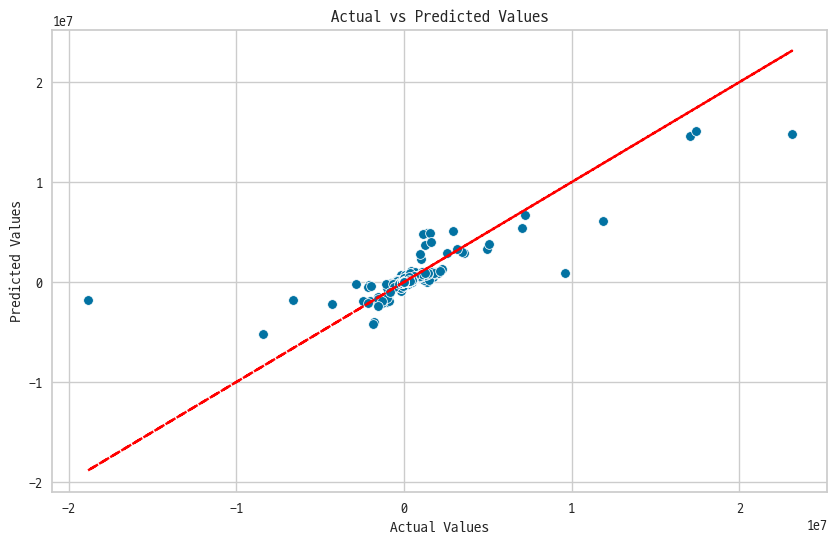

In [137]:
# 제일 좋은 수치모델로 시각화
predicted_values = best_model.predict(X_test)
actual_values = y_test

# 산점도와 회귀선 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.plot(actual_values, actual_values, color='red', linestyle='--')

plt.show()

C:\Users\yeonn\AppData\Local\Temp\ipykernel_25116\3667919476.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\yeonn\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


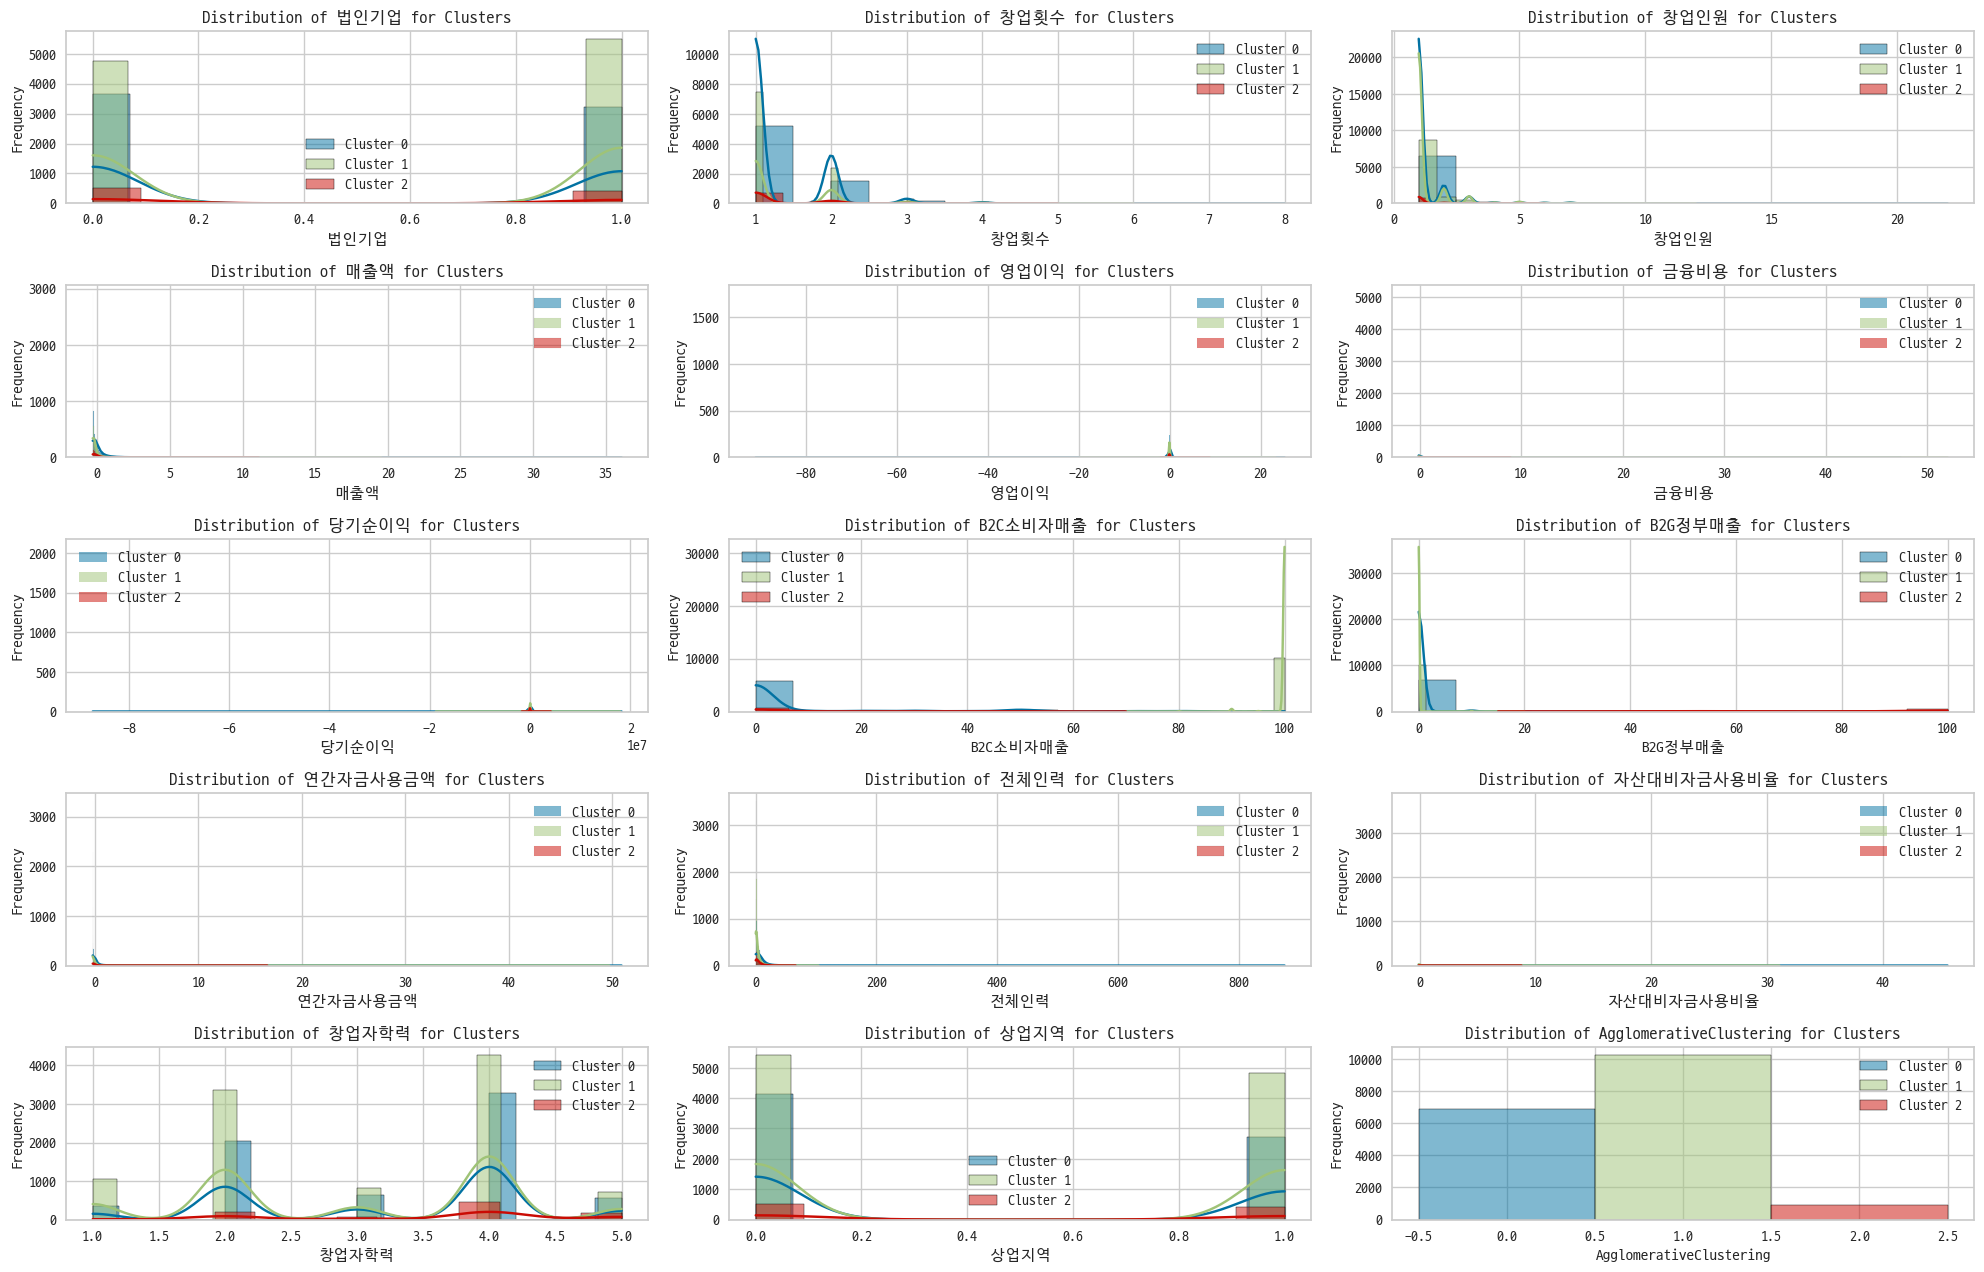

In [138]:
# 군집 별로 변수의 분포를 시각화
plt.figure(figsize=(20, 15))
for i, column in enumerate(train_df.columns):
    plt.subplot(6, 3, i+1)
    for cluster_id in range(3):
        sns.histplot(train_df[train_df['AgglomerativeClustering'] == cluster_id][column], kde=True, label=f'Cluster {cluster_id}', alpha=0.5)
    plt.title(f'Distribution of {column} for Clusters')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()